In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# CONSTANTS:
ROUND = '221'
TOURNAMENT_NAME = "kazutsugi"
TARGET_NAME = f"target_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"

In [3]:
# Load Data
training_data = pd.read_hdf(f"../../dataset/numerai_dataset_{ROUND}/numerai_training_data.hdf").set_index("id")
tournament_data = pd.read_hdf(f"../../dataset/numerai_dataset_{ROUND}/numerai_tournament_data.hdf").set_index("id")

In [4]:
tournament_data.query("data_type=='validation'").head(2)

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_strength1,feature_strength2,feature_strength3,feature_strength4,feature_strength5,feature_strength6,feature_strength7,feature_strength8,feature_strength9,feature_strength10,feature_strength11,feature_strength12,feature_strength13,feature_strength14,feature_strength15,feature_strength16,feature_strength17,feature_strength18,feature_strength19,feature_strength20,feature_strength21,feature_strength22,feature_strength23,feature_strength24,feature_strength25,feature_strength26,feature_strength27,feature_strength28,feature_strength29,feature_strength30,feature_strength31,feature_strength32,feature_strength33,feature_strength34,feature_strength35,feature_strength36,feature_strength37,feature_strength38,feature_dexterity1,feature_dexterity2,feature_dexterity3,feature_dexterity4,feature_dexterity5,feature_dexterity6,feature_dexterity7,feature_dexterity8,feature_dexterity9,feature_dexterity10,feature_dexterity11,feature_dexterity12,feature_dexterity13,feature_dexterity14,feature_constitution1,feature_constitution2,feature_constitution3,feature_constitution4,feature_constitution5,feature_constitution6,feature_constitution7,feature_constitution8,feature_constitution9,feature_constitution10,feature_constitution11,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_consti

In [5]:
# FEATURES
feature_names = [f for f in training_data.columns if f.startswith("feature")]

---

In [6]:
def build_model(learning_rate, layer_size):
    """ Build Keras model
        #feature -relu-> #layer -relu,l2-> #layer -sigmoid-> 1
        MSE by Adam
    """
    model = keras.Sequential([
        layers.Dense(layer_size, activation='relu', input_shape=[len(feature_names)]),
        layers.Dropout(0.3),  # 3割間引く
        layers.Dense(layer_size, activation='relu', kernel_regularizer='l2'),
        layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [10]:
def train_model(model, feature, label, num_epochs, batch_size):
    """Train Keras Model"""
    history = model.fit(x=feature,
                        y=label,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=[tournament_data.query("data_type=='validation'")[feature_names],
                                         tournament_data.query("data_type=='validation'")[TARGET_NAME]],
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')]
    )
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [11]:
# build model & training
model = build_model(0.0001, layer_size=100)
epochs, hist = train_model(
    model,
    training_data[feature_names],
    training_data[TARGET_NAME],
    num_epochs=1000,
    batch_size=100
)

Train on 501808 samples, validate on 106895 samples
Epoch 1/1000
501808/501808 [==============================] - 10s 19us/sample - loss: 0.2379 - mae: 0.3011 - mse: 0.1249 - val_loss: 0.1249 - val_mae: 0.3003 - val_mse: 0.1248
Epoch 2/1000
501808/501808 [==============================] - 12s 23us/sample - loss: 0.1246 - mae: 0.3002 - mse: 0.1245 - val_loss: 0.1249 - val_mae: 0.3006 - val_mse: 0.1248
Epoch 3/1000
501808/501808 [==============================] - 13s 27us/sample - loss: 0.1245 - mae: 0.3005 - mse: 0.1245 - val_loss: 0.1249 - val_mae: 0.3014 - val_mse: 0.1249
Epoch 00003: early stopping


In [22]:
# model.save_weights('param.hdf5')

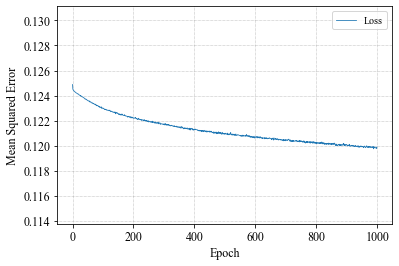

In [43]:
# plot error history
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(epochs, hist.mse, label="Loss")
plt.ylim([hist.mse.min() * 0.95, hist.mse.max() * 1.05])
plt.legend();

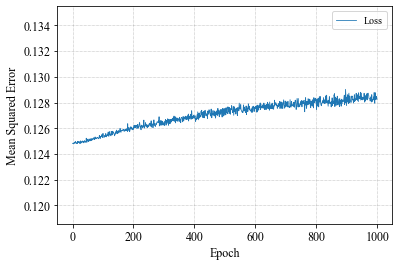

In [48]:
# plot error history
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(epochs, hist.val_mse, label="Loss")
plt.ylim([hist.val_mse.min() * 0.95, hist.val_mse.max() * 1.05])
plt.legend();

In [49]:
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,0.234594,0.301244,0.124880,0.124912,0.300371,0.124834
1,0.124574,0.300216,0.124522,0.124856,0.300675,0.124818
2,0.124502,0.300519,0.124451,0.124872,0.301065,0.124824
3,0.124468,0.300693,0.124415,0.124870,0.301222,0.124822
4,0.124442,0.300797,0.124388,0.124911,0.301559,0.124859


---

- Cross Validation
- PearsonCorr(Payout)計算
- Sharpe計算

In [21]:
import financialml

In [12]:
prediction_out = pd.DataFrame(model.predict(tournament_data[feature_names]),
                              index=tournament_data.index)

In [13]:
prediction_out

,0
id,
n0003aa52cab36c2,0.486335
n000920ed083903f,0.490838
n0038e640522c4a6,0.524778
n004ac94a87dc54b,0.486366
n0052fe97ea0c05f,0.493915
...,...
nffcc17d1f826dfb,0.496995
nffdf07d10258832,0.508255
nffe4987b4a95c09,0.525061


In [19]:
val_predict = tournament_data.query("data_type == 'validation'")[[TARGET_NAME]].join(prediction_out)

In [30]:
rank_corr = np.corrcoef(val_predict[TARGET_NAME], val_predict[0].rank(pct=True, method="first"))[0,1]

In [31]:
spearman_corr

0.015071102015030756